In [10]:
import torch
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig

In [11]:
import importlib

In [12]:
import dataextract
importlib.reload(dataextract)
resulteye0, resulthand0, maxlen0 = dataextract.plainsequences('ASD')
resulteye1, resulthand1, maxlen1 = dataextract.plainsequences('TD')


In [13]:
len(resulteye0), len(resulteye1)

(24, 50)

In [14]:
total = 0
sum = 0
for i in range(len(resulteye0)):
    sum+=len(resulteye0[i])
    total+=1
for i in range(len(resulteye1)):
    sum+=len(resulteye1[i])
    total+=1  
print(sum/total) 


150.54054054054055


In [15]:
eyes = resulteye0+resulteye1
hands = resulthand0+resulthand1


In [16]:
pip install --index-url https://download.pytorch.org/whl/cpu torch torchvision torchaudio


Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [17]:
import torch
print(torch.__version__)
print(torch.__file__)

2.2.2
/opt/anaconda3/lib/python3.9/site-packages/torch/__init__.py


In [18]:
# --- imports / data ---
import os, csv, time, importlib
import torch
import matplotlib.pyplot as plt
import numpy as np

sequences = eyes
labels = [1]*len(resulteye0) + [-1]*len(resulteye1)


In [19]:
#sample sequences 
newseq = []
newlabels = []
for i in range(len(sequences)):
    if len(sequences[i])<1000:
        newseq.append(sequences[i])
        newlabels.append(labels[i])
    else:
        endpoint = 45
        while endpoint+45<len(sequences[i]):
            newseq.append(sequences[i][endpoint-45:endpoint])
            newlabels.append(labels[i])
            endpoint+=45
        newseq.append(sequences[i][endpoint-45:len(sequences[i])])
        newlabels.append(labels[i])


In [20]:
print(len(newseq), len(newlabels))

74 74


In [21]:
sequences = newseq
labels = newlabels

In [22]:
import importlib

In [23]:

import collator
importlib.reload(collator)

# Stratified split by subject/bag (no leakage)
all_ids = list(range(len(sequences)))
train_ids, val_ids = collator.stratified_split(all_ids, labels, test_size=0.25, seed=0)
# === CHOOSE ONE of the two augmentation paths ===

# --- model build ---
import modeling
importlib.reload(modeling)

context_length = 53
slide_stride   = 16
encoder, cfg = modeling.build_frozen_patchtst(
    repo_id="namctin/patchtst_etth1_pretrain",
    num_input_channels=2,
    context_length=context_length,
    patch_length=12,
    patch_stride=1,
    use_cls_token=True,
    fine_tune_last_n_layers=2,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
encoder.to(device).eval()

import mil
importlib.reload(mil)

mil_head = mil.MILHead2D(
    d_model=encoder.config.d_model,
    use_cls_token=True,
    dropout=0.3,
).to(device)

decay, no_decay = [], []
for n,p in mil_head.named_parameters():
    (no_decay if ('bias' in n or 'score_bias' in n) else decay).append(p)

optimizer = torch.optim.AdamW(
    [{"params": decay, "weight_decay": 1e-6, "lr": 3e-4},
     {"params": no_decay, "weight_decay": 0.0, "lr": 3e-4}]
)

# >>> later when calling trainer:
# train with train_ids_used; validate with val_ids
# (if you extended the dataset, be sure to pass sequences_used & labels_tensor built from labels_used)


/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
# ===================== BEST-HINGE & BEST-TP-WEIGHTED-F1 TRAIN LOOP =====================
# --- training utilities ---
import trainer
importlib.reload(trainer)
import confusionplot
import os, csv, time
import matplotlib.pyplot as plt
run_dir = "mil_runs"
os.makedirs(run_dir, exist_ok=True)
cur_ts  = time.strftime("%Y%m%d-%H%M%S")
tag     = f"bag_manual_{cur_ts}"
labels_tensor = torch.tensor(labels, dtype=torch.long)
run_dir = "mil_runs"
os.makedirs(run_dir, exist_ok=True)
cur_ts = time.strftime("%Y%m%d-%H%M%S")
tag    = f"bag_manual_{cur_ts}"
csv_path         = os.path.join(run_dir, f"{tag}.csv")
curves_png_loss  = os.path.join(run_dir, f"{tag}_loss.png")
curves_png_acc   = os.path.join(run_dir, f"{tag}_acc.png")

best_hinge_ckpt_path     = os.path.join(run_dir, f"{tag}_bestHinge.pt")
best_hinge_cm_png        = os.path.join(run_dir, f"{tag}_val_confusion_bestHinge.png")
best_hinge_cm_norm_png   = os.path.join(run_dir, f"{tag}_val_confusion_bestHinge_norm.png")
best_hinge_csv_path      = os.path.join(run_dir, f"{tag}_bestHinge.csv")

best_tpf1_ckpt_path      = os.path.join(run_dir, f"{tag}_bestTPF1.pt")
best_tpf1_cm_png         = os.path.join(run_dir, f"{tag}_val_confusion_bestTPF1.png")
best_tpf1_cm_norm_png    = os.path.join(run_dir, f"{tag}_val_confusion_bestTPF1_norm.png")
best_tpf1_csv_path       = os.path.join(run_dir, f"{tag}_bestTPF1.csv")
best_tpf1_encoder_path = os.path.join(run_dir, f"{tag}_bestTPF1_encoder.pt")
best_tpf1_mil_path     = os.path.join(run_dir, f"{tag}_bestTPF1_mil.pt")
curves_png_loss   = os.path.join(run_dir, f"{tag}_loss.png")
curves_png_acc    = os.path.join(run_dir, f"{tag}_acc.png")
best_cm_png       = os.path.join(run_dir, f"{tag}_val_confusion_best.png")
best_cm_norm_png  = os.path.join(run_dir, f"{tag}_val_confusion_best_norm.png")

# ------------------------------------------------------------
# history (you can keep this for plotting in-memory if you like)
hist = {
    "epoch": [],
    "train_hinge": [],
    "train_acc": [],
    "val_hinge": [],
    "val_acc": [],
    "val_bal_acc": [],
    "val_precision": [],
    "val_recall": [],
    "val_roc_auc": [],
    "val_pr_auc": [],
    "val_f1": [],
    "val_weighted_acc": [],
    "val_tpf1": [],          # TP-weighted F1 (on validation, using train-calibrated threshold)
}


epochs = 140
bags_per_batch = 8
best_val_hinge_seen = float("inf")
best_hinge_state = None
best_hinge_epoch = -1

best_tpf1_seen = -1.0
best_tpf1_state = None
best_tpf1_epoch = -1
TOP_K  = 3
POS_W = 2.0   # loss/metrics weight for ASD
NEG_W = 1.0
TP_W  = 1.2   # how much to upweight *true positives* when computing TP-weighted F1
MARGIN_POS = 1.0
MARGIN_NEG = 1.0

# ### NEW: toggles
save_all_confusions = True            # save a confusion image each epoch
save_every_ckpt     = 0               # set to e.g. 50 to save a checkpoint every 50 epochs (0 = off)

# ### NEW: ensure CSV exists with header
csv_header = [
    "epoch", "train_hinge", "train_acc",
    "val_hinge", "val_acc", "val_bal_acc",
    "val_precision", "val_recall", "val_roc_auc", "val_pr_auc",
    "tn", "fp", "fn", "tp"
]
if not os.path.exists(csv_path):
    with open(csv_path, "w", newline="") as f:
        csv.writer(f).writerow(csv_header)

for epoch in range(epochs):
    # ---- train epoch
    train_hinge = trainer.train_one_epoch_manual_bag(
        encoder=encoder,
        mil_head=mil_head,
        sequences=sequences,
        labels_tensor=labels_tensor,
        bag_indices=train_ids,
        context_length=context_length,
        stride=slide_stride,
        bags_per_batch=bags_per_batch,
        optimizer=optimizer,
        device=device,
        pad_short=True,
        add_noise=0.0,
        seed=42 + epoch,
        k=TOP_K,
    )

    # ---- train eval (acc for sanity)
    train_hinge_eval, train_acc = trainer.evaluate_manual_bag(
        encoder=encoder,
        mil_head=mil_head,
        sequences=sequences,
        labels_tensor=labels_tensor,
        bag_indices=train_ids,
        context_length=context_length,
        stride=slide_stride,
        bags_per_batch=bags_per_batch,
        device=device,
        pad_short=True,
        k=TOP_K,
        return_confusion=False,
    )

    # ---- val eval (full metrics)
    val_hinge, val_acc, val_cm, val_metrics = trainer.evaluate_manual_bag(
        encoder=encoder,
        mil_head=mil_head,
        sequences=sequences,
        labels_tensor=labels_tensor,
        bag_indices=val_ids,
        context_length=context_length,
        stride=slide_stride,
        bags_per_batch=bags_per_batch,
        device=device,
        pad_short=True,
        k=TOP_K,
        return_confusion=True,
    )


    tn, fp, fn, tp = int(val_cm[0,0]), int(val_cm[0,1]), int(val_cm[1,0]), int(val_cm[1,1])
    prec = float(val_metrics["precision"])
    rec  = float(val_metrics["recall"])
    f1   = (2.0 * prec * rec / (prec + rec)) if (prec + rec) > 0 else 0.0

    tn, fp = int(val_cm[0, 0]), int(val_cm[0, 1])
    fn, tp = int(val_cm[1, 0]), int(val_cm[1, 1])

    P, N = tp + fn, tn + fp
    den = POS_W * P + NEG_W * N if (POS_W * P + NEG_W * N) > 0 else 1.0
    val_weighted_acc = (POS_W * tp + NEG_W * tn) / den

    tp_w  = TP_W * tp
    prec_w = tp_w / (tp_w + fp) if (tp_w + fp) > 0 else 0.0
    rec_w  = tp_w / (tp_w + fn) if (tp_w + fn) > 0 else 0.0
    tpf1  = (2.0 * prec_w * rec_w / (prec_w + rec_w)) if (prec_w + rec_w) > 0 else 0.0 
    print(
        f"Epoch {epoch:04d} | "
        f"train_hinge={train_hinge:.4f} | train_acc={train_acc:.3f} | "
        f"val_hinge={val_hinge:.4f} | val_acc={val_acc:.3f} | "
        f"bal_acc={val_metrics['balanced_acc']:.3f} | "
        f"P={prec:.3f} R={rec:.3f} | F1={f1:.3f} | "
        f"TPF1={tpf1:.3f} (TP_W={TP_W}) | "
        f"ROC-AUC={val_metrics['roc_auc']:.3f} | PR-AUC={val_metrics['pr_auc']:.3f} | "
        f"(TP={tp}, TN={tn}, FP={fp}, FN={fn})"
    )

    # ---- in-memory log (optional but nice for plots)
    hist["epoch"].append(epoch)
    hist["train_hinge"].append(float(train_hinge))
    hist["train_acc"].append(float(train_acc))
    hist["val_hinge"].append(float(val_hinge))
    hist["val_acc"].append(float(val_acc))
    hist["val_bal_acc"].append(float(val_metrics["balanced_acc"]))
    hist["val_precision"].append(float(prec))
    hist["val_recall"].append(float(rec))
    hist["val_roc_auc"].append(float(val_metrics["roc_auc"]))
    hist["val_pr_auc"].append(float(val_metrics["pr_auc"]))
    hist["val_f1"].append(float(f1))
    hist["val_weighted_acc"].append(float(val_weighted_acc))
    hist["val_tpf1"].append(float(tpf1))

    # ### NEW: append this epoch to CSV immediately
    with open(csv_path, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow([
            epoch, float(train_hinge), float(train_acc),
            float(val_hinge), float(val_acc), float(val_metrics["balanced_acc"]),
            float(val_metrics["precision"]), float(val_metrics["recall"]),
            float(val_metrics["roc_auc"]), float(val_metrics["pr_auc"]), 
            tn, fp, fn, tp
        ])

    # ### NEW: optionally save a confusion image for every epoch
    if val_hinge < best_val_hinge_seen - 1e-9:
        best_val_hinge_seen = float(val_hinge)
        best_hinge_epoch = epoch

        try:
            confusionplot.plot_confusion(val_cm, class_names=("TD", "ASD"),
                                         normalize=False, outpath=best_hinge_cm_png)
            confusionplot.plot_confusion(val_cm, class_names=("TD", "ASD"),
                                         normalize=True,  outpath=best_hinge_cm_norm_png)
            print(f"  → Saved BEST-HINGE confusion to {best_hinge_cm_png} and {best_hinge_cm_norm_png} "
                  f"(val_hinge={best_val_hinge_seen:.4f})")
        except Exception as e:
            print("  ! Could not save BEST-HINGE confusion plot:", e)

        best_hinge_state = {
            "mil_head": mil_head.state_dict(),
            "epoch": epoch,
            "selection": "best_hinge",
            "top_k": TOP_K,
            "train_hinge": float(train_hinge),
            "val_hinge": float(val_hinge),
            "val_acc": float(val_acc),
            "val_cm": val_cm,
            "val_metrics": val_metrics,
            "tp_weighted_f1": float(tpf1),
            "encoder_frozen": True,
            "weights": {"pos": POS_W, "neg": NEG_W, "tp_w": TP_W},
            "margins": {"pos": MARGIN_POS, "neg": MARGIN_NEG},
        }
        torch.save(best_hinge_state, best_hinge_ckpt_path)
        print(f"  → Saved BEST-HINGE checkpoint to {best_hinge_ckpt_path}")

        with open(best_hinge_csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow([
                "epoch", "val_hinge", "val_acc", "balanced_acc",
                "precision", "recall", "F1", "TPF1", "ROC_AUC", "PR_AUC",
                "TP", "TN", "FP", "FN",
                "cm_png", "cm_norm_png", "ckpt_path"
            ])
            w.writerow([
                epoch, val_hinge, val_acc, val_metrics["balanced_acc"],
                prec, rec, f1, tpf1, val_metrics["roc_auc"], val_metrics["pr_auc"],
                tp, tn, fp, fn,
                best_hinge_cm_png, best_hinge_cm_norm_png, best_hinge_ckpt_path
            ])
        print(f"  → Wrote best-hinge CSV: {best_hinge_csv_path}")

    if tpf1 > best_tpf1_seen + 1e-9:
        best_tpf1_seen = float(tpf1)
        best_tpf1_epoch = epoch

        try:
            confusionplot.plot_confusion(val_cm, class_names=("TD", "ASD"),
                                         normalize=False, outpath=best_tpf1_cm_png)
            confusionplot.plot_confusion(val_cm, class_names=("TD", "ASD"),
                                         normalize=True,  outpath=best_tpf1_cm_norm_png)
            print(f"  → Saved BEST-TPF1 confusion to {best_tpf1_cm_png} and {best_tpf1_cm_norm_png} "
                  f"(TPF1={best_tpf1_seen:.4f})")
        except Exception as e:
            print("  ! Could not save BEST-TPF1 confusion plot:", e)

        # -- inside: if tpf1 > best_tpf1_seen + 1e-9: ...
        best_tpf1_state = {
            "epoch": epoch,
            "selection": "best_tpf1",
            "top_k": TOP_K,
            "train_hinge": float(train_hinge),
            "val_hinge": float(val_hinge),
            "val_acc": float(val_acc),
            "val_cm": val_cm,
            "val_metrics": val_metrics,
            "tp_weighted_f1": float(tpf1),
            "encoder_frozen": True,
            "weights": {"pos": POS_W, "neg": NEG_W, "tp_w": TP_W},
            "margins": {"pos": MARGIN_POS, "neg": MARGIN_NEG},

            # NEW: models
            "mil_head": {k: v.detach().cpu() for k, v in mil_head.state_dict().items()},
            "encoder":  {k: v.detach().cpu() for k, v in encoder.state_dict().items()},
        }

        torch.save(best_tpf1_state, best_tpf1_ckpt_path)
        print(f"  → Saved BEST-TPF1 checkpoint (mil_head + encoder) to {best_tpf1_ckpt_path}")
        torch.save({k: v.detach().cpu() for k, v in mil_head.state_dict().items()},
                best_tpf1_mil_path)
        torch.save({k: v.detach().cpu() for k, v in encoder.state_dict().items()},
                best_tpf1_encoder_path)
        with open(best_tpf1_csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow([
                "epoch", "val_hinge", "val_acc", "balanced_acc",
                "precision", "recall", "F1", "TPF1", "ROC_AUC", "PR_AUC",
                "TP", "TN", "FP", "FN",
                "cm_png", "cm_norm_png", "ckpt_path"
            ])
            w.writerow([
                epoch, val_hinge, val_acc, val_metrics["balanced_acc"],
                prec, rec, f1, tpf1, val_metrics["roc_auc"], val_metrics["pr_auc"],
                tp, tn, fp, fn,
                best_tpf1_cm_png, best_tpf1_cm_norm_png, best_tpf1_ckpt_path
            ])
        print(f"  → Wrote best-TPF1 CSV: {best_tpf1_csv_path}")



if best_hinge_state is not None:
    m = best_hinge_state.get("val_metrics", {})
    print(f"\nBest-by-HINGE @ epoch={best_hinge_epoch} | "
          f"val_hinge={best_hinge_state['val_hinge']:.4f} | "
          f"val_acc={best_hinge_state['val_acc']:.3f} | "
          f"balanced_acc={m.get('balanced_acc', float('nan')):.3f} | "
          f"P={m.get('precision', float('nan')):.3f} R={m.get('recall', float('nan')):.3f} | "
          f"TPF1={best_hinge_state.get('tp_weighted_f1', float('nan')):.3f}")
else:
    print("\nNo best-hinge state captured.")

if best_tpf1_state is not None:
    m = best_tpf1_state.get("val_metrics", {})
    print(f"\nBest-by-TPF1 @ epoch={best_tpf1_epoch} | "
          f"val_hinge={best_tpf1_state['val_hinge']:.4f} | "
          f"val_acc={best_tpf1_state['val_acc']:.3f} | "
          f"balanced_acc={m.get('balanced_acc', float('nan')):.3f} | "
          f"P={m.get('precision', float('nan')):.3f} R={m.get('recall', float('nan')):.3f} | "
          f"TPF1={best_tpf1_state.get('tp_weighted_f1', float('nan')):.3f}")
else:
    print("\nNo best-TPF1 state captured.")

with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([
        "epoch", "train_hinge", "train_acc",
        "val_hinge", "val_acc", "val_bal_acc",
        "val_precision", "val_recall", "val_f1",
        "val_roc_auc", "val_pr_auc", "val_weighted_acc", "val_tpf1"
    ])
    for i in range(len(hist["epoch"])):
        w.writerow([
            hist["epoch"][i], hist["train_hinge"][i], hist["train_acc"][i],
            hist["val_hinge"][i], hist["val_acc"][i], hist["val_bal_acc"][i],
            hist["val_precision"][i], hist["val_recall"][i], hist["val_f1"][i],
            hist["val_roc_auc"][i], hist["val_pr_auc"][i], hist["val_weighted_acc"][i], hist["val_tpf1"][i],
        ])
print(f"[CSV saved] {csv_path}")

try:
    from IPython.display import FileLink, display
    display(FileLink(csv_path))
    display(FileLink(best_hinge_csv_path))
    display(FileLink(best_tpf1_csv_path))
except Exception:
    pass
plt.figure()
plt.plot(hist["epoch"], hist["train_hinge"], label="train_hinge")
plt.plot(hist["epoch"], hist["val_hinge"], label="val_hinge")
plt.xlabel("Epoch"); plt.ylabel("Hinge loss")
plt.title("MIL training and validation hinge")
plt.legend(); plt.tight_layout()
plt.savefig(curves_png_loss, dpi=160); plt.close()
print(f"Saved loss curve to {curves_png_loss}")

plt.figure()
plt.plot(hist["epoch"], hist["train_acc"], label="train_acc")
plt.plot(hist["epoch"], hist["val_acc"], label="val_acc")
plt.plot(hist["epoch"], hist["val_bal_acc"], label="val_bal_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("MIL train/validation accuracy (incl. balanced)")
plt.legend(); plt.tight_layout()
plt.savefig(curves_png_acc, dpi=160); plt.close()
print(f"Saved accuracy curve to {curves_png_acc}")

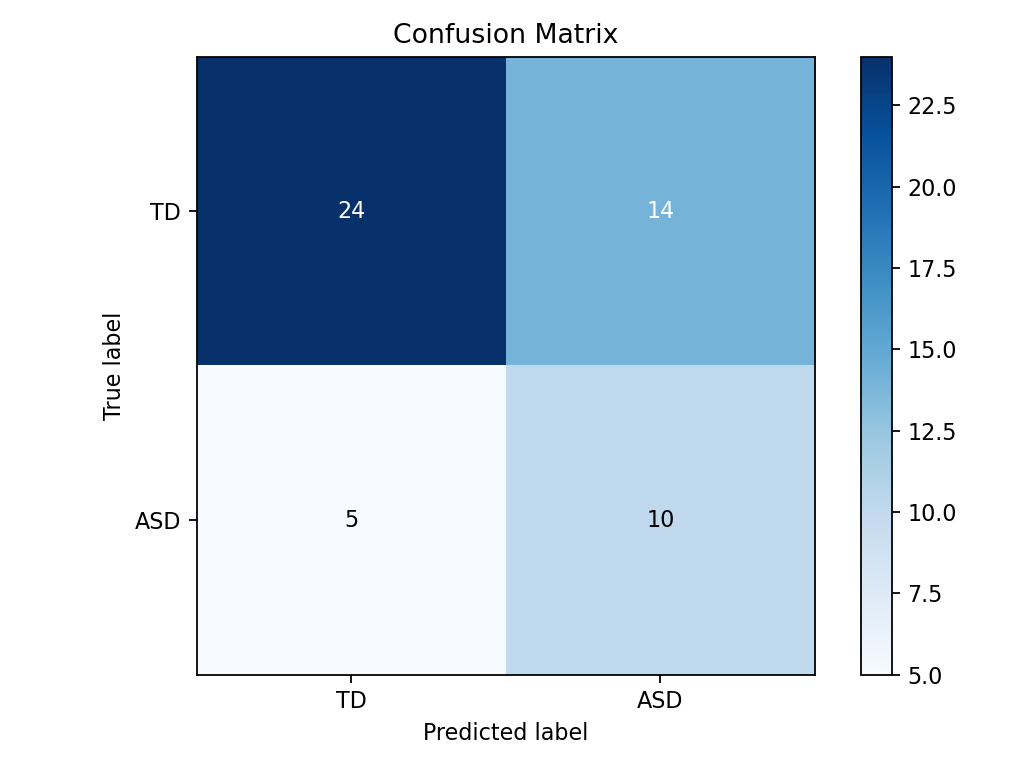

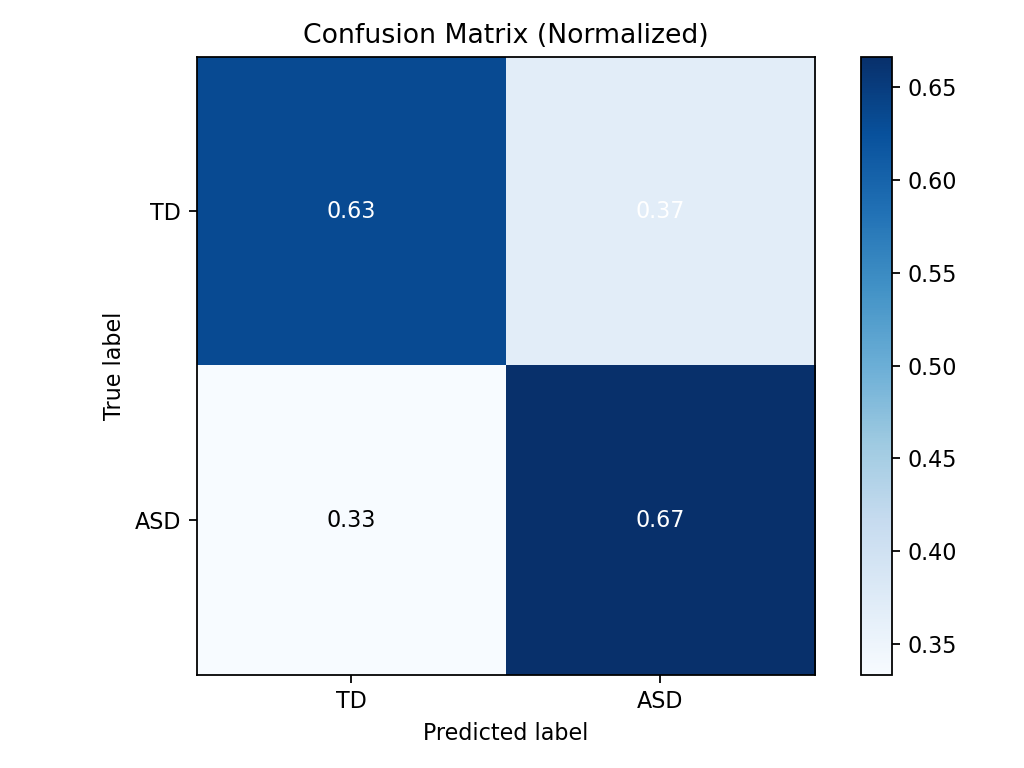

In [25]:
importlib.reload(confusionplot)

ckpt, shown_pngs, tag = confusionplot.load_confusion_from_csv(
    "mil_runs/bag_manual_20250910-115536.csv",
    mil_head=mil_head,
    device=device,
    kind="bestTPF1",   # or "best" / "hinge"
)

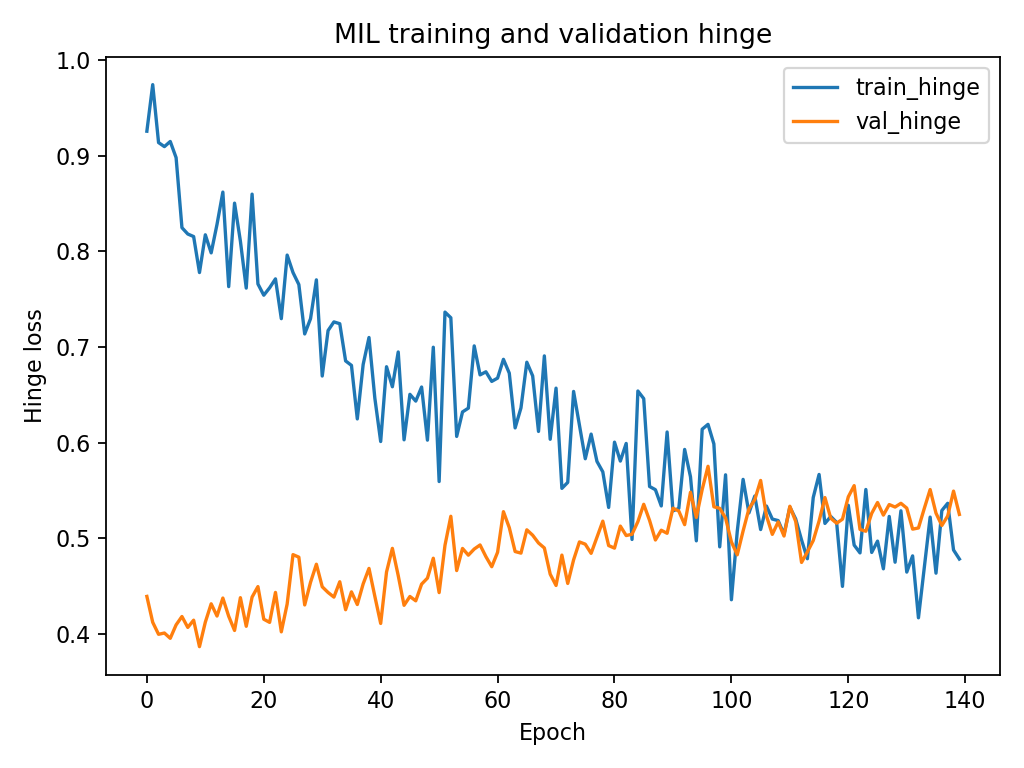

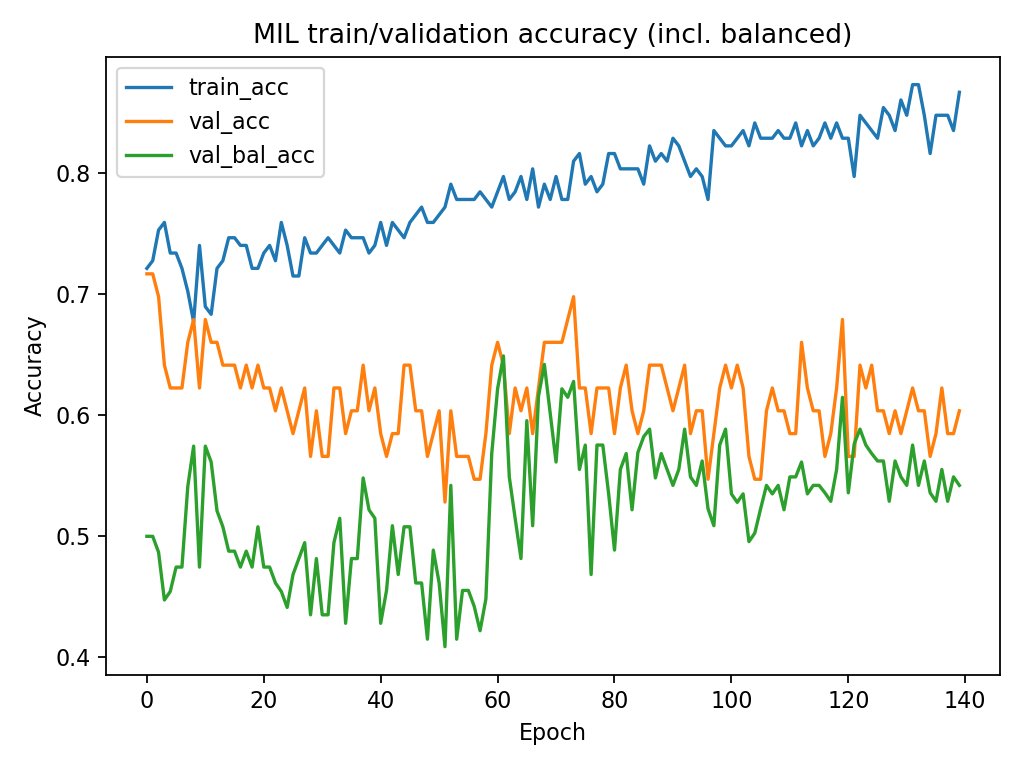

In [26]:
from IPython.display import Image, display
display(Image(filename="mil_runs/bag_manual_20250910-115536_loss.png"))
display(Image(filename="mil_runs/bag_manual_20250910-115536_acc.png"))

[INFO] Scanning 6 ASD-labelled validation bags...
[DONE] Generated 6 plots in mil_runs/qual_plots
  - {'seq_id': 14, 'path': 'mil_runs/qual_plots/bag_manual_20250910-115536_bag14_inst4_points_two_tone.png', 's': 64, 'e': 117, 'bag_score': 0.29729536175727844}


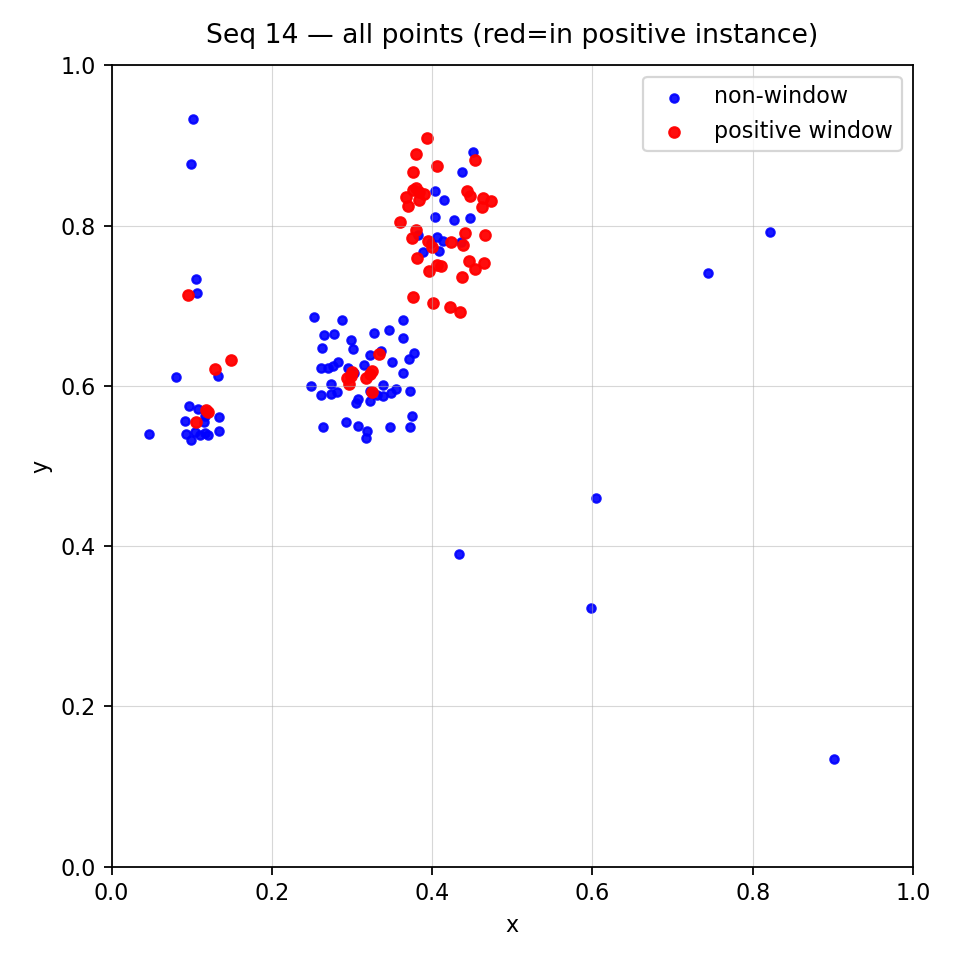

  - {'seq_id': 0, 'path': 'mil_runs/qual_plots/bag_manual_20250910-115536_bag0_inst7_points_two_tone.png', 's': 108, 'e': 161, 'bag_score': 0.2986815571784973}


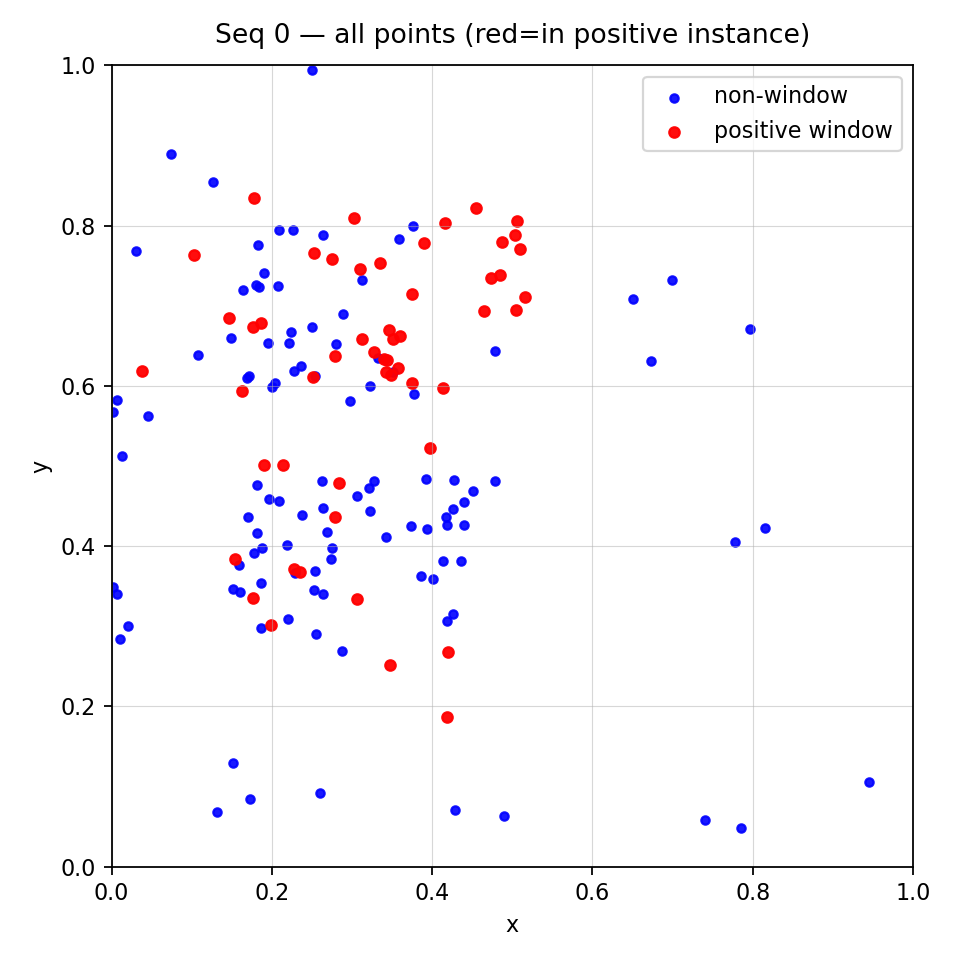

  - {'seq_id': 17, 'path': 'mil_runs/qual_plots/bag_manual_20250910-115536_bag17_inst0_points_two_tone.png', 's': 0, 'e': 53, 'bag_score': 0.17525510489940643}


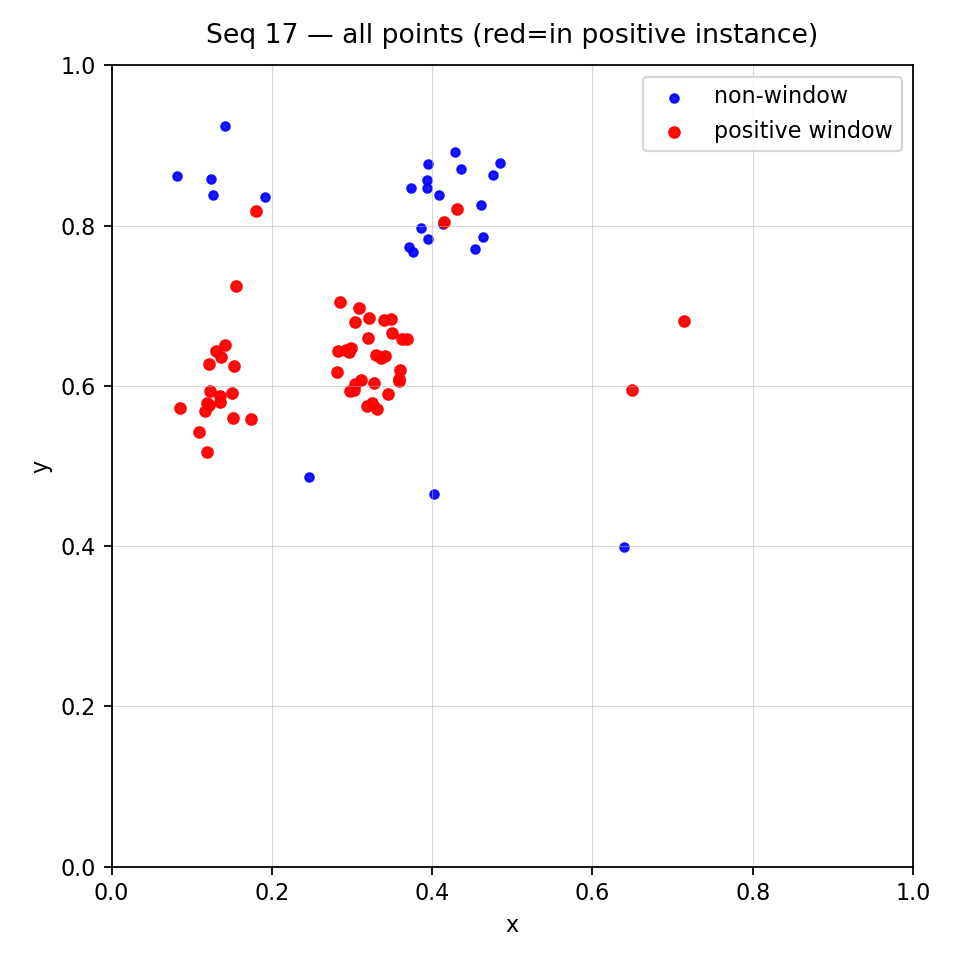

  - {'seq_id': 7, 'path': 'mil_runs/qual_plots/bag_manual_20250910-115536_bag7_inst4_points_two_tone.png', 's': 52, 'e': 105, 'bag_score': 0.1539219319820404}


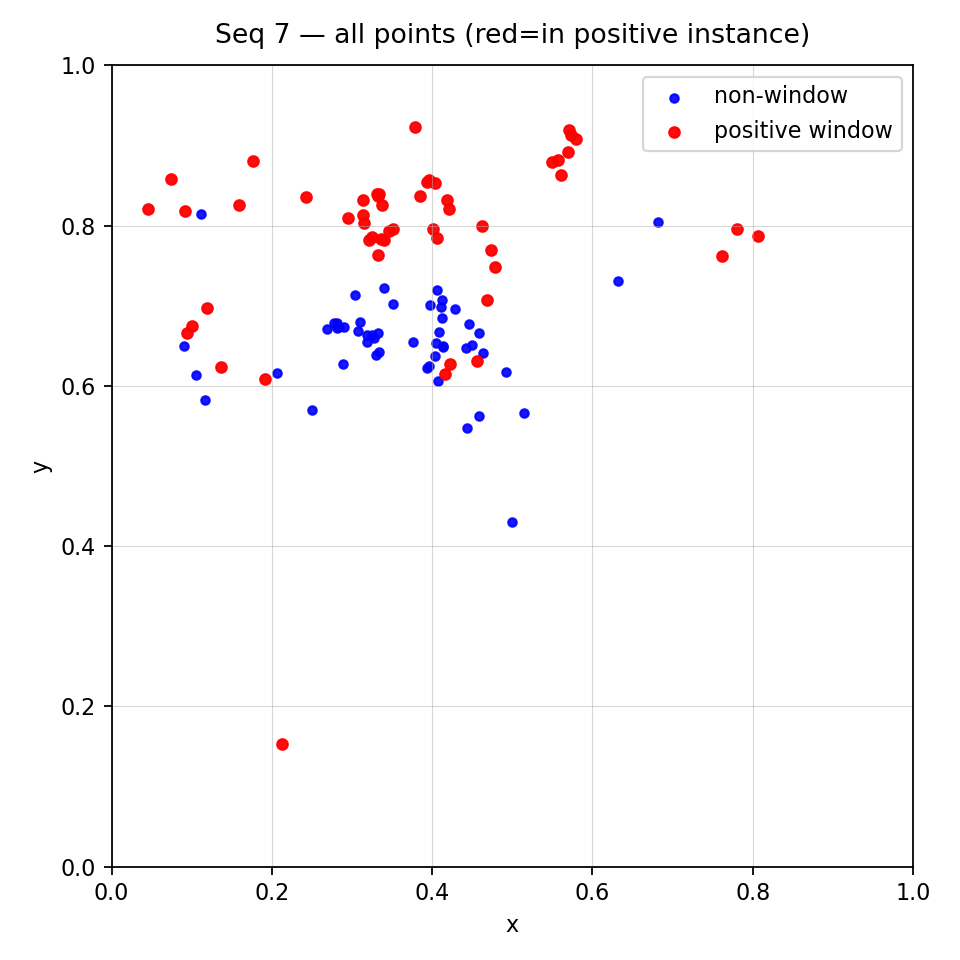

  - {'seq_id': 6, 'path': 'mil_runs/qual_plots/bag_manual_20250910-115536_bag6_inst0_points_two_tone.png', 's': 0, 'e': 53, 'bag_score': 0.16573138535022736}


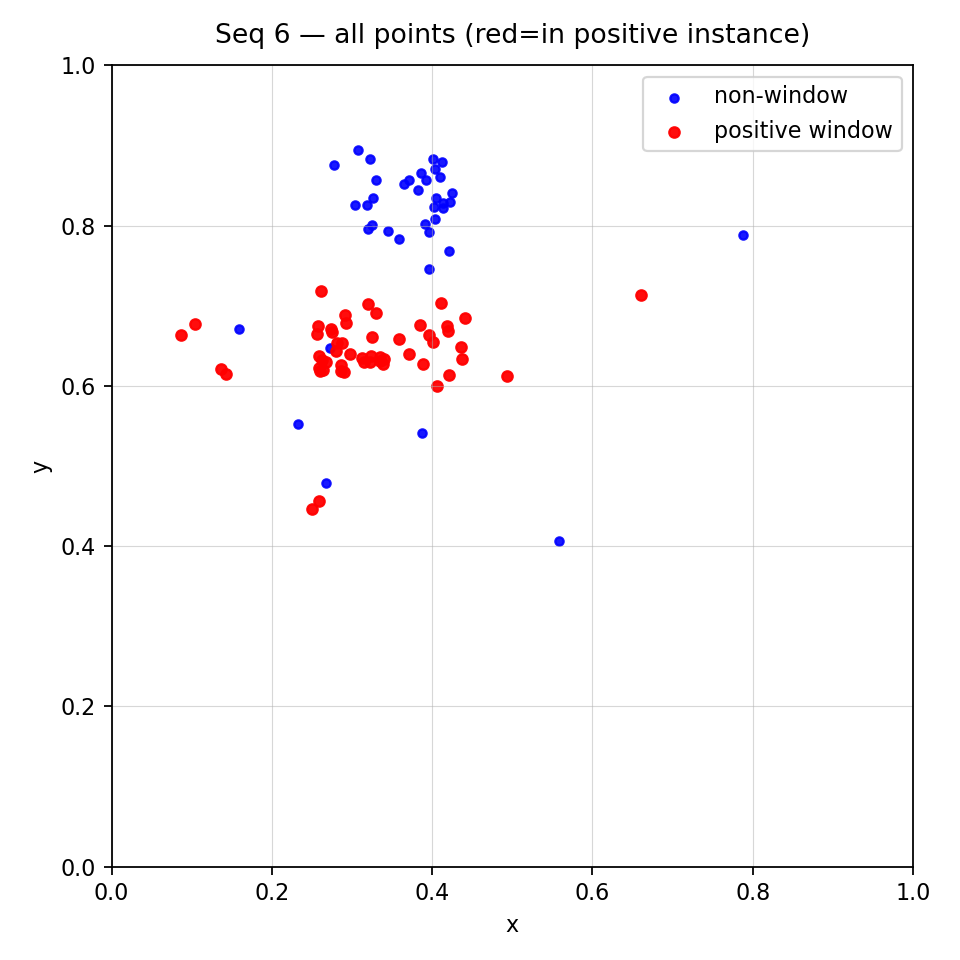

  - {'seq_id': 11, 'path': 'mil_runs/qual_plots/bag_manual_20250910-115536_bag11_inst4_points_two_tone.png', 's': 64, 'e': 117, 'bag_score': 0.2313053160905838}


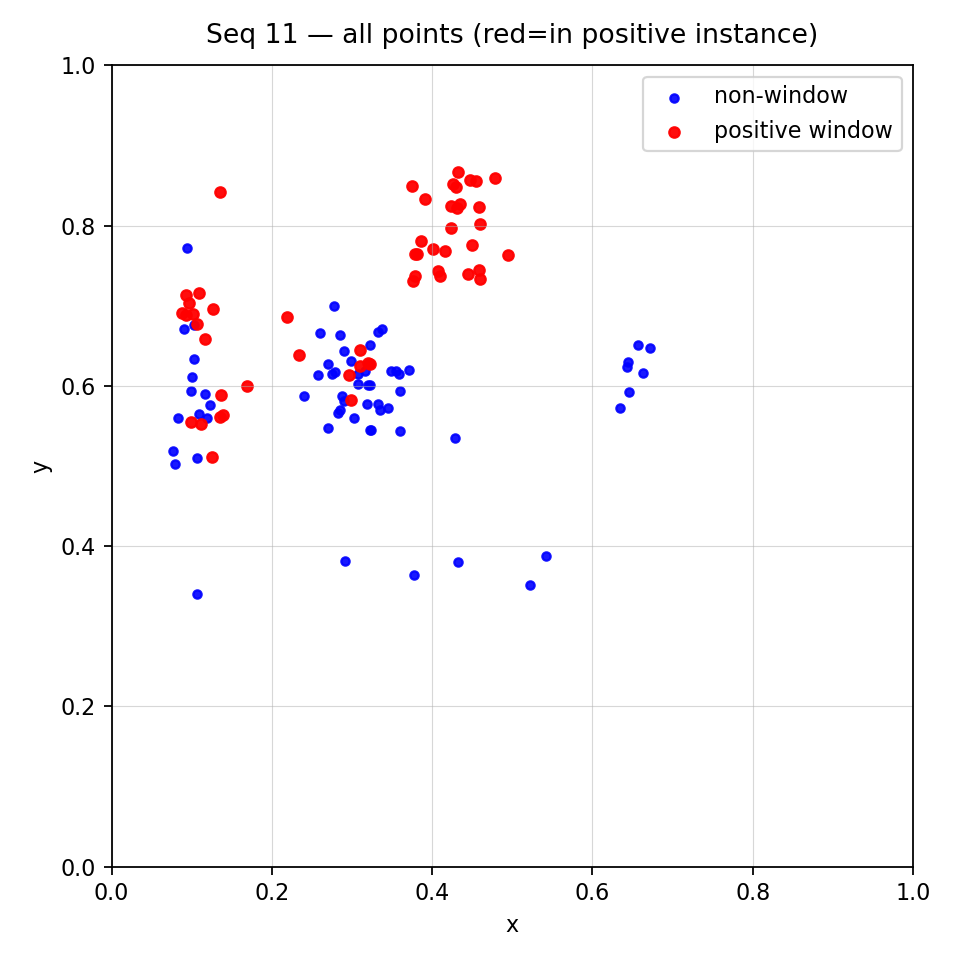

In [27]:
import os, importlib, torch
from copy import deepcopy
from IPython.display import Image, display
import evaluater
importlib.reload(evaluater)
seq_id=4
# 1) restore modules from checkpoint (ckpt has state_dicts)
ckpt = torch.load(best_tpf1_ckpt_path, map_location="cpu")
encoder_best  = deepcopy(encoder).cpu()
mil_head_best = deepcopy(mil_head).cpu()
encoder_best.load_state_dict(ckpt["encoder"], strict=False)
mil_head_best.load_state_dict(ckpt["mil_head"], strict=False)
encoder_best.to(device).eval()
mil_head_best.to(device).eval()

_ = evaluater.plot_all_correct_positive_bags(
    sequences=sequences,
    labels_tensor=labels_tensor,
    val_ids=val_ids,
    encoder_module=encoder_best,    # or encoder
    mil_head_module=mil_head_best,  # or mil_head
    context_length=context_length,
    stride=slide_stride,
    device=device,
    run_dir=run_dir,
    tag=tag,
    pad_short=True,
    k=TOP_K,
    threshold=0.0,
    all_ids=all_ids,       # if sequences is indexed differently; else None
    show_first=8,
)
